# PREDICTING HEART DISEASE

In [31]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
hdisease = pd.read_csv('heart_disease_prediction.csv')
hdisease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
hdisease.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# Descriptive Statistics


1. Average age: 53.5
2. Odd statistics: RestingBP min, Cholesterol min, FastingBS min, Cholesterol median higher than mean 

# Bar Charts

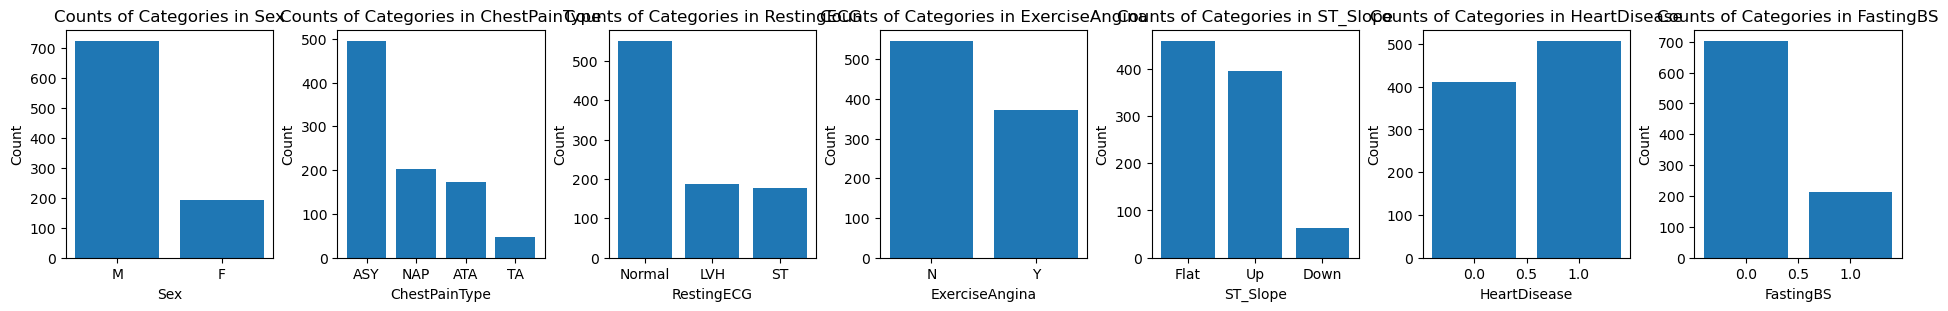

In [5]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, len(hdisease.select_dtypes(include='object')))
num_columns = hdisease.select_dtypes(include='object').shape[1]+2
fig, ax = plt.subplots(1, num_columns, figsize=(19,3), constrained_layout=True)

for i, col in enumerate(list(hdisease.select_dtypes(include='object'))+['HeartDisease','FastingBS']):
    counts = hdisease[col].value_counts()
    ax[i].bar(counts.index, counts.values)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')
    ax[i].set_title(f'Counts of Categories in {col}')
plt.show() 

#### Insights from Bar Charts 
1. Significantly more males vs. females
2. Patients most often have chest pain type: ASY
3. RestingECG is overwhelmingly normal
4. More often than not heart disease patients do not have exercise angina
5. Very uncommon for patients to have ST_Slope than is down

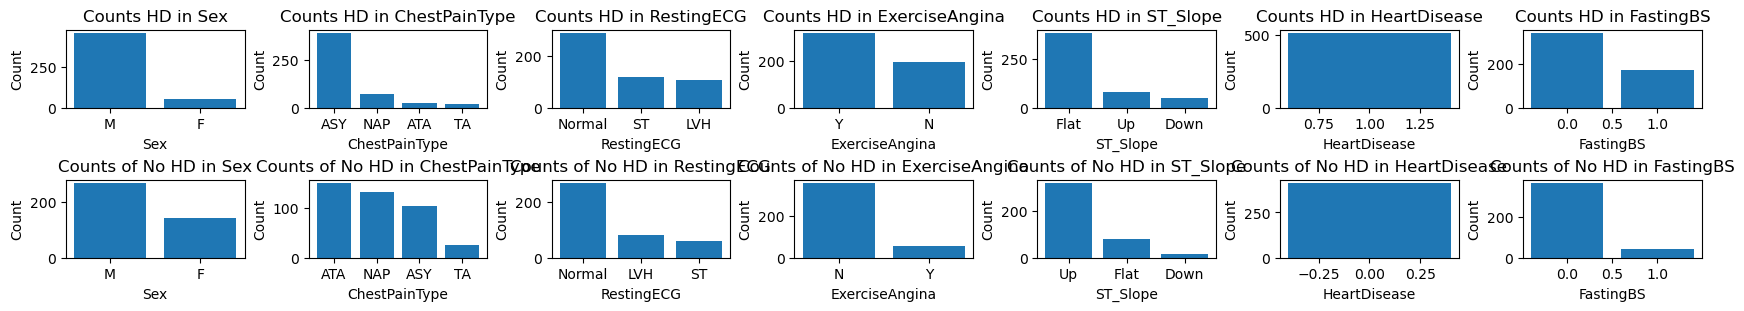

In [6]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, len(hdisease.select_dtypes(include='object')))
num_columns = hdisease.select_dtypes(include='object').shape[1]+2
fig, ax = plt.subplots(2, num_columns, figsize=(17,3), constrained_layout=True)

for i, col in enumerate(list(hdisease.select_dtypes(include='object'))+['HeartDisease','FastingBS']):
    countNoHD = hdisease.groupby(['HeartDisease'])[col].value_counts()[0]
    countHD = hdisease.groupby(['HeartDisease'])[col].value_counts()[1]
    ax[0,i].bar(countHD.index, countHD.values)
    ax[0,i].set_xlabel(col)
    ax[0,i].set_ylabel('Count')
    ax[0,i].set_title(f'Counts HD in {col}')
    ax[1,i].bar(countNoHD.index, countNoHD.values)
    ax[1,i].set_xlabel(col)
    ax[1,i].set_ylabel('Count')
    ax[1,i].set_title(f'Counts of No HD in {col}')
plt.show() 


#### Insights from Bar Charts On HeartDisease GroupBy
1. HD patients are overwhelmingly male
2. HD patients are much more likely to have ASY chest pain
3. Non HD patients are much much less likely to experience exercise angina
4. HD patients are more likely to have flat ST slope vs an up ST slope in Non HD patients

# Scatter Plots

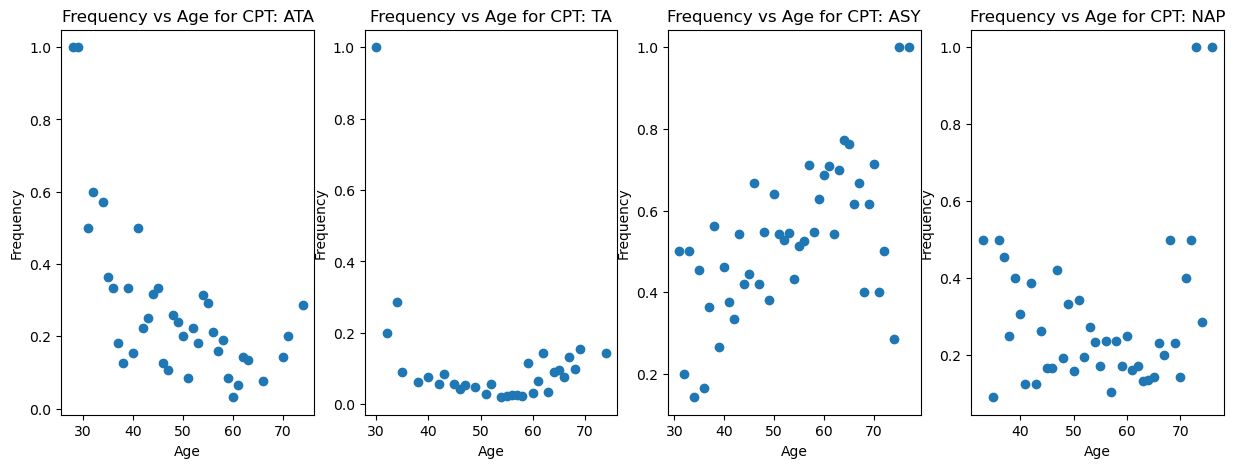

In [7]:
CPTAge = hdisease.groupby(['Age'])['ChestPainType'].value_counts()
CPTAgeCounts = hdisease.groupby(['Age'])['ChestPainType'].count()

AgeDict = {}
CPT_types = []

for col in CPTAge.index:
    age = col[0]
    CPT = col[1]
    if CPT not in CPT_types:
        CPT_types.append(CPT)
    count = CPTAge[col]
    frequency = count/CPTAgeCounts[age]
    if age not in AgeDict.keys():
        AgeDict[age] = {}
    AgeDict[age][CPT] = frequency
    
fig, ax = plt.subplots(1, 4, figsize=(15,5))
    
for i, CPT in enumerate(CPT_types):
    frequencies = []
    for age in AgeDict.keys():
        if CPT in AgeDict[age].keys():
            frequencies.append(AgeDict[age][CPT])
        else:
            frequencies.append(None)
    ax[i].scatter(AgeDict.keys(), frequencies)
    ax[i].set_xlabel('Age')
    ax[i].set_ylabel('Frequency')
    ax[i].set_title(f'Frequency vs Age for CPT: {CPT}')
plt.show()

#### Insights from Scatter Plots
1. ATA type CPT decreases with age
2. No strong frequency correlation with age for TA
3. Fairly strong correlation between frequency and age for ASY
4. No strong conclusions between frequency and age for NAP

# Data Cleaning
    

In [8]:
zeroBP = hdisease[hdisease['RestingBP'] == 0]
zeroCholesterol = hdisease[hdisease['Cholesterol'] == 0]
HDBPmean = hdisease[hdisease['HeartDisease'] == 1]['RestingBP'].median()
NOHDBPmean = hdisease[hdisease['HeartDisease'] == 0]['RestingBP'].median()
HDCholmean = hdisease[hdisease['HeartDisease'] == 1]['Cholesterol'].median()
NOHDCholmean = hdisease[hdisease['HeartDisease'] == 0]['Cholesterol'].median()
hdisease.loc[(hdisease['RestingBP'] == 0) & (hdisease['HeartDisease'] == 0), 'RestingBP'] = NOHDBPmean
hdisease.loc[(hdisease['RestingBP'] == 0) & (hdisease['HeartDisease'] == 1), 'RestingBP'] = HDBPmean
hdisease.loc[(hdisease['Cholesterol'] == 0) & (hdisease['HeartDisease'] == 0), 'Cholesterol'] = NOHDCholmean
hdisease.loc[(hdisease['Cholesterol'] == 0) & (hdisease['HeartDisease'] == 1), 'Cholesterol'] = HDCholmean


# Heatmapping

In [9]:
# create dummy variables
catFeatures = hdisease.select_dtypes('object').columns
catFeatures
hdisease_dummies = pd.get_dummies(hdisease, columns = catFeatures, drop_first=True)
hdisease_dummies


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,1,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236,0,174,0.0,1,0,1,0,0,0,0,0,1,0


<AxesSubplot:>

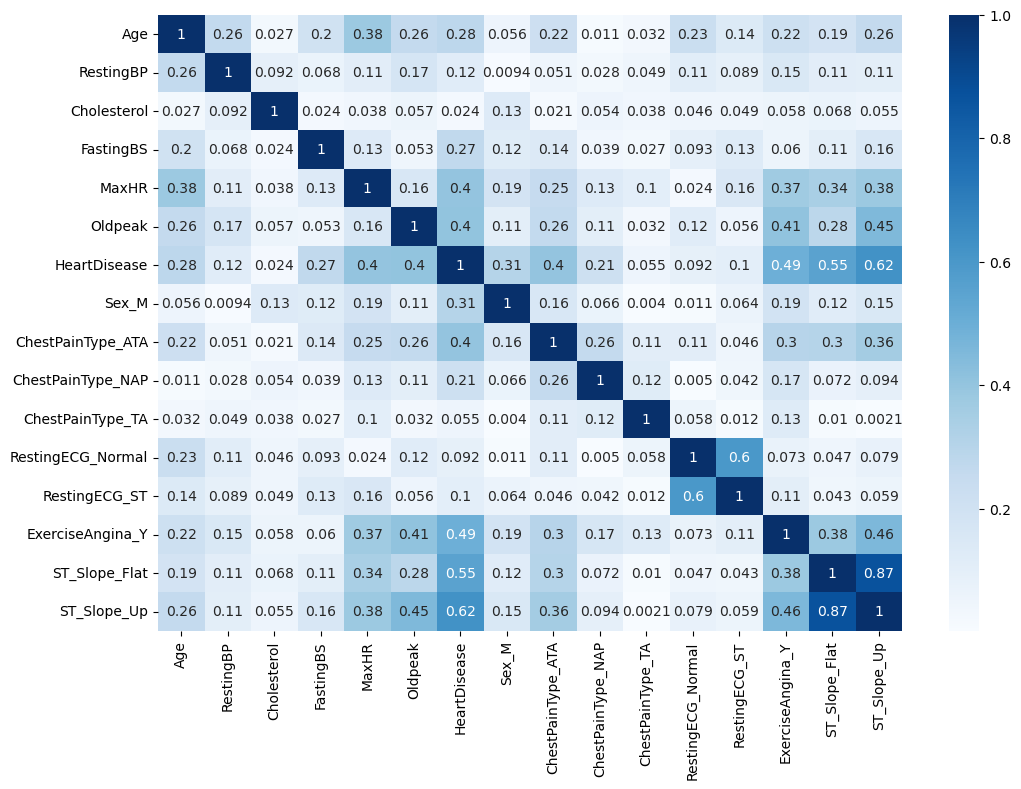

In [10]:
import seaborn as sns
correlations = abs(hdisease_dummies.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

# KNN modeling

In [20]:
X = hdisease_dummies.drop(['HeartDisease'], axis=1)
y = hdisease_dummies['HeartDisease']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(accuracy)
    

0.6902173913043478
0.6358695652173914
0.7119565217391305
0.7989130434782609
0.8206521739130435


 #### KNN insights
 1. it appears as if ST_Slope_Up is the strongest model, while Sex_M is the weakest model. This makes sense as in the heat map, we see a strongest correlation between HeartDisease and ST_Slope_Up and the weakest with Sex_M.

# Using GridSearchCV

In [34]:
X = hdisease_dummies.drop(['HeartDisease'], axis=1)
y = hdisease_dummies['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=417)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

params = {"n_neighbors": range(1,20),
          "metric": ["minkowski","manhattan"]}

knn_grid = GridSearchCV(knn, params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

print(knn_grid.best_score_, knn_grid.best_params_)

prediction = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, prediction)
print(accuracy)

0.8460348522970833 {'metric': 'minkowski', 'n_neighbors': 10}
0.8315217391304348


#### GridSearchCV insights
1. Tuning our hyperparameters with GridSearchCV resulted in a slightly more accurate model, with a 2.5% increase at 84.6% compared to 82% in the single feature model. 
2. We see slightly better performance in the validation set as compared to the test set. This may be due to the selection for test